# Icebert Clustering

This notebook guides you through the creation of objects necessary to the pre-training of an ICEBERT language model, as described in [Transformers-IcebertMLM](https://github.com/BassaniRiccardo/transformers/tree/master/examples/pytorch/language-modeling).

The following objects will be created at the end of the notebook:
- cID mapper: a dictionary containing the cluster ID of each token in the vocabulary
- Baseline tokenizer: the tokenizer of the baseline model
- ICEBERT tokenizer: the tokenizer of the ICEBERT model
- Monolingual tokenizers: a folder containing monolingual tokenizers to be used in the mapping-to-cIDs process

*Notes*: 
- The set of languages can be modified in the "Packages, Libraries, Variables and Methods" section.
- The code will retrun slightly different results at each run, due to the randomic nature of the METIS partitioning algorithm.

We start by mounting the drive: the downloaded/created files will be saved there:

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0. Packages, Libraries, Variables and Methods


We define:
- a repo folder, the root folder of this project
- an obects folder, the root folder for the objects to save

In [36]:
! export REPO_FOLDER=/content/drive/MyDrive/notebooks/icebert_clustering
! export OBJECTS_FOLDER=$REPO_FOLDER/objects

In [48]:
! echo $OBJECTS_FOLDER

/content/drive/MyDrive/notebooks/icebert_clustering/objects


We create the folder structure for the objects we want to create:

In [ ]:
# ! mkdir $OBJECTS_FOLDER
# ! mkdir $OBJECTS_FOLDER/voc_dicts
# ! mkdir $OBJECTS_FOLDER/voc_dicts_inv
# ! mkdir $OBJECTS_FOLDER/embs
# ! mkdir $OBJECTS_FOLDER/embs/monolingual
# ! mkdir $OBJECTS_FOLDER/embs/multilingual
# ! mkdir $OBJECTS_FOLDER/for_tokenizer_vocabs
# ! mkdir $OBJECTS_FOLDER/translation_graphs

mkdir: missing operand
Try 'mkdir --help' for more information.


We clone the repository necessary for cross-lingual embedding mapping:

In [ ]:
# % cd /content/drive/MyDrive/notebooks/icebert_clustering/
# ! git clone https://github.com/codogogo/xling-eval.git

We install necessary packages and import necessary methods:

In [37]:
! pip install sentencepiece
! pip install transformers
! pip install pytorch_transformers
! pip install tqdm

In [38]:
import numpy as np

# import util
import os
import sys
import pickle
from datetime import datetime
import time
from sys import stdin
from collections import defaultdict
from collections import OrderedDict
import community
from scipy import sparse
import networkx as nx
import numpy as np
from tqdm import tqdm

# xling-eval libraries
sys.path.append('/content/drive/MyDrive/notebooks/icebert_clustering/xling-eval/code')
import util
import sims
import projection

We define some important utility functions:

In [39]:
def inverse_dict(my_dict, unique=False):
    result_dict = {}
    if unique:
      for key, value in my_dict.items():
        result_dict[value] = key
    else:
      for key, value in my_dict.items():
        if not value in result_dict.keys():
          result_dict[value] = []
        result_dict[value].append(key)
    return result_dict


# saves an object in the 'objects' folder
def save_obj(obj, name, folder='', protocol=pickle.HIGHEST_PROTOCOL):
  if folder == '':
    file_name = OBJECTS_FOLDER + name + '.pkl'
  else:
    file_name = OBJECTS_FOLDER + folder + '/' + name + '.pkl'
  with open(file_name, 'wb') as f:
    pickle.dump(obj, f, protocol)


# loads an object from the 'objects' folder
def load_obj(name, folder='', protocol=pickle.HIGHEST_PROTOCOL):
  if folder == '':
    file_name = OBJECTS_FOLDER + name + '.pkl'
  else:
    file_name = OBJECTS_FOLDER + folder + '/' + name + '.pkl'
  with open(file_name, 'rb') as f:
    return pickle.load(f)

def remove_punctuation_digits_from_voc(voc, map_digits_to_zero=True):
  """
  Modifies a vocabulary by removing all punctuation and digits.
  Returns the modified voc and the list of removed punctuation and digits.
  """
  new_voc = []
  punctuation_digits = []
  for token in voc:
    t = effective_token(token)
    if (not t in punctuation) and (not t.isdigit()):
      new_voc.append(token)
    else:
      punctuation_digits.append(token)
  return new_voc, punctuation_digits

def effective_token(s):
  """
  Returns the token ingoring the '##' markers
  """
  if '##' == s[:2]:
    return s[2:]
  return s

We define the languages to include and some important variables:

In [40]:
id_to_ln = {0: 'ar', 1: 'bn', 2: 'en', 3: 'fi', 4: 'id', 5 : 'ko', 6 : 'ru', 7 : 'sw', 8 : 'te'}  
ln_to_id = inverse_dict(id_to_ln, unique=True)

all_ln = ['ar', 'bn', 'en', 'fi', 'id', 'ko', 'ru', 'sw', 'te']
map_ln = all_ln
languages = ['Arabic', 'Bengali', 'English', 'Finnish', 'Indonesian' , 'Korean', 'Russian', 'Swahili', 'Telugu'] 

OBJECTS_FOLDER = "/content/drive/MyDrive/notebooks/icebert_clustering/objects"
MON_EMBEDDINGS_ROOT = OBJECTS_FOLDER + "/embs/monolingual/vectors_"

# 1. BPEmb Mapping

In this section:
- We download monolinugal vocabularies and embeddings
- We save monolinugal and multilingual (mapped into a shared space) embeddings

We use the BPEmb package to download monolingual embeddings:

In [ ]:
! pip install bpemb
from bpemb import BPEmb

While we directly download the vocabularies, so that we can:
- select the size we want (30k);
- change the subwords marker to "##";
- extract the embeddings for the vocab we use;

We save everything in our BPEmb folder.

---

We download vocabularies of size 25K and 50K, to extract 30K tokens vocabularies:

In [ ]:
!wget https://nlp.h-its.org/bpemb/ar/ar.wiki.bpe.vs25000.vocab
!wget https://nlp.h-its.org/bpemb/bn/bn.wiki.bpe.vs25000.vocab
!wget https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.vocab
!wget https://nlp.h-its.org/bpemb/fi/fi.wiki.bpe.vs25000.vocab
!wget https://nlp.h-its.org/bpemb/id/id.wiki.bpe.vs25000.vocab
!wget https://nlp.h-its.org/bpemb/ko/ko.wiki.bpe.vs25000.vocab
!wget https://nlp.h-its.org/bpemb/ru/ru.wiki.bpe.vs25000.vocab
!wget https://nlp.h-its.org/bpemb/sw/sw.wiki.bpe.vs25000.vocab
!wget https://nlp.h-its.org/bpemb/te/te.wiki.bpe.vs25000.vocab

In [ ]:
!wget https://nlp.h-its.org/bpemb/ar/ar.wiki.bpe.vs50000.vocab
!wget https://nlp.h-its.org/bpemb/bn/bn.wiki.bpe.vs50000.vocab
!wget https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs50000.vocab
!wget https://nlp.h-its.org/bpemb/fi/fi.wiki.bpe.vs50000.vocab
!wget https://nlp.h-its.org/bpemb/id/id.wiki.bpe.vs50000.vocab
!wget https://nlp.h-its.org/bpemb/ko/ko.wiki.bpe.vs50000.vocab
!wget https://nlp.h-its.org/bpemb/ru/ru.wiki.bpe.vs50000.vocab
!wget https://nlp.h-its.org/bpemb/sw/sw.wiki.bpe.vs50000.vocab
!wget https://nlp.h-its.org/bpemb/te/te.wiki.bpe.vs50000.vocab

We need:
 * Monolingual vocabularies including (multilingual) backoff characters, punctuation and digits, to be used by the tokenizer --> for_tokenizer_vocabs
 * Monolingual "clean" vocabulary, to be used in the clustering --> voc_dicts and voc_dicts_inv
 * Mulitlingual set of shared tokens, including:
  * punctuation
  * digits
  * backoff characters
  ---> special tokens

Each language is tokenized monolingually, then:
- each token queries the tok_to_cID dictionary
- if the key is not present, the query is repeated after unmarking the token (to find interlingua special tokens)
- if the key is absent, "UNK" cID is given.

Set a limit for the number of special characters each language can have This is necessary since special characters are selected as the ones present at the end of different size vocabularies. While for most languages the set of such characters has a reasonably low size, for some languages like Begnali or Korean special character would be too many, and the final vocabulary would be of bad quality.

In [ ]:
from string import punctuation

special_chars_limit = {}
for ln in all_ln:
  special_chars_limit[ln] = 500
special_chars_limit["bn"] = 216
special_chars_limit["ko"] = 0

We extract a vocabulary of size 30k from a voc of size 50k and one of size 25k:

In [ ]:
def extract_vocab_dict_old(ln, size=30000, include_characters=False, voc_fil_path="/content/", essential_chars=punctuation):
  """
  Access two text files containing two different sized BPEmb dictionaries.
  Select the desired number of tokens, keeping the special characters at the end of the text files.
  Requires the two files fo size SMALL and BIG to be in the - voc_fil_path - directory.
  Allows to extract a vocabulary of size s.t. SMALL < size < BIG
  """
  complete_voc = []
  voc_dict = {}
  voc_dict_inv = {}
  # to retrieve the embeddings
  tok_to_index = {}
  with open (voc_fil_path +ln + ".wiki.bpe.vs25000.vocab", 'r') as voc_25, open(voc_fil_path +ln + ".wiki.bpe.vs50000.vocab", 'r') as voc_50:
    # select the desired number of lines
    lines_25 = voc_25.readlines()
    lines_50 = voc_50.readlines()
    useful_lines = []
    first_useful_index = 3
    # find backoff characters (including some punctuation): they are shared by all-size vocs at the end
    backoff_characters = []
    special_chars_index = -1
    while (lines_25[special_chars_index].split()[0] == lines_50[special_chars_index].split()[0]):
      token = lines_50[special_chars_index].split()[0]
      token = ''.join("0" if c.isdigit() else c for c in token)
      if token[0] == "▁" and not token == "▁":
        token = token[1:]
      else:
        token = "##" + token
      backoff_characters.append(token)
      special_chars_index -= 1
    # keeping the special characters at the end of the text file
    if include_characters: 
      useful_lines.extend(backoff_characters)
    # if too many backoff characters, keep them as normal characters
    if not include_characters and len(backoff_characters) > special_chars_limit[ln]:
      useful_lines.extend(lines_50[special_chars_index : -special_chars_limit[ln]])          # all tyhe tokens beyond then max number are considered normal
    # or excluding them
    useful_lines.extend(lines_50[first_useful_index : first_useful_index + size])

    # add each token to the vocabulary
    for enum, line in enumerate(useful_lines):
      try:
        token, index = line.split()
      except:
        print(line)
        print(enum + first_useful_index)
        return
      token = ''.join("0" if c.isdigit() else c for c in token)
      if token[0] == "▁" and not token == "▁":
        token = token[1:]
      else:
        token = "##" + token
      # make sure there are not duplicates due to the digits substitution
      if not token in complete_voc:
        complete_voc.append(token)
        tok_to_index[token] = int(index[1:]) + 3

  # remove punctuation and digits, and return a dictionary tok->id and one id->tok. Also return pd 
  voc_no_pd, special = MergeVoc.remove_punctuation_digits_from_voc(complete_voc)
  print(ln, "Vocab length:", len(voc_no_pd))
  for i, t in enumerate(voc_no_pd):
    voc_dict[t] = i
    voc_dict_inv[i] = t

  # also return a vocabulary including punctuation, digits and backoff chars (also the unmarked version), to be used by the tokenizer  
  complete_voc.extend(backoff_characters)
  # korean, or "symbolic" languages in general, have a lot of single characters to keep: they are kept in the voc and not as special tokens
  if len(backoff_characters) > special_chars_limit[ln]:
    special.extend(backoff_characters[: special_chars_limit[ln]])
  else:
    special.extend(backoff_characters)

  # make sure all the characters are present both hashed and non-hashed
  for c in special:
    if c[:2] == "##" and c[2:] not in complete_voc:
      special.append(c[2:])
      complete_voc.append(c[2:])

  # make sure essential characters (punctuation) are included
  for c in essential_chars:
    if c not in complete_voc:
      complete_voc.append(c)
    if c not in special:
      special.append(c)

  return voc_dict, voc_dict_inv, tok_to_index, complete_voc, special

Just take the 25k vocabulary to avoid missing important tokens:

In [ ]:
def extract_vocab_dict(ln, size = 30000, voc_fil_path="/content/", essential_chars=punctuation):
  """
  Access two text files containing two different sized BPEmb dictionaries.
  Select the desired number of tokens, keeping the special characters at the end of the text files.
  Requires the two files fo size SMALL and BIG to be in the - voc_fil_path - directory.
  Allows to extract a vocabulary of size s.t. SMALL < size < BIG
  """
  complete_voc = []
  voc_dict = {}
  voc_dict_inv = {}
  # to retrieve the embeddings
  tok_to_index = {}
  with open (voc_fil_path +ln + ".wiki.bpe.vs25000.vocab", 'r') as voc_25, open(voc_fil_path +ln + ".wiki.bpe.vs50000.vocab", 'r') as voc_50:
    
    # select the desired number of lines
    lines_25 = voc_25.readlines()
    lines_50 = voc_50.readlines()
    useful_lines = []
    first_useful_index = 3
        
    # get tokens indexes from the 50k voc so we can retrieve the embeddings
    tok_to_index_50 = dict()
    for line in lines_50[first_useful_index:]:
      token, index = line.split()
      token = ''.join("0" if c.isdigit() else c for c in token)
      if token[0] == "▁" and not token == "▁":
        token = token[1:]
      else:
        token = "##" + token
      tok_to_index_50[token] = int(index[1:]) + 3


    # find backoff characters (including some punctuation): they are shared by all-size vocs at the end
    backoff_characters = []
    special_chars_index = -1
    while (lines_25[special_chars_index].split()[0] == lines_50[special_chars_index].split()[0]):
      token = lines_25[special_chars_index].split()[0]
      token = ''.join("0" if c.isdigit() else c for c in token)
      if token[0] == "▁" and not token == "▁":
        token = token[1:]
      else:
        token = "##" + token
      backoff_characters.append(token)
      special_chars_index -= 1
    # exclude special chars from the tokens to cluster
    # if too many backoff characters, keep them as normal characters
    if len(backoff_characters) > special_chars_limit[ln]:
      special_chars_index = -special_chars_limit[ln]
    # select the tokens to cluster
    useful_lines.extend(lines_25[first_useful_index : special_chars_index])   # include all tokens from the 25k vocabulary

    # add each token to the vocabulary
    for enum, line in enumerate(useful_lines):
      try:
        token, index = line.split()
      except:
        print(line)
        print(enum + first_useful_index)
        return
      token = ''.join("0" if c.isdigit() else c for c in token)
      if token[0] == "▁" and not token == "▁":
        token = token[1:]
      else:
        token = "##" + token
      # make sure there are not duplicates due to the digits substitution
      if not token in complete_voc:
        complete_voc.append(token)

    # add extra tokens to reach 30k
    count = len(complete_voc)
    for enum, line in enumerate(lines_50[first_useful_index:]):
      try:
        token, index = line.split()
      except:
        print(line)
        print(enum + first_useful_index)
        return
      token = ''.join("0" if c.isdigit() else c for c in token)
      if token[0] == "▁" and not token == "▁":
        token = token[1:]
      else:
        token = "##" + token
      # make sure there are not duplicates due to the digits substitution
      if not token in complete_voc:
        complete_voc.append(token)
        count +=1
      # when the desired size is reached, terminate
      if not count < size:
        break

  # remove punctuation and digits, and return a dictionary tok->id and one id->tok. Also return pd 
  voc_no_pd, special = remove_punctuation_digits_from_voc(complete_voc)
  print(ln, "Vocab length:", len(voc_no_pd))
  for i, t in enumerate(voc_no_pd):
    voc_dict[t] = i
    voc_dict_inv[i] = t

  # also return a vocabulary including punctuation, digits and backoff chars (also the unmarked version), to be used by the tokenizer  
  complete_voc.extend(backoff_characters)
  # korean, or "symbolic" languages in general, have a lot of single characters to keep: they are kept in the voc and not as special tokens
  if len(backoff_characters) > special_chars_limit[ln]:
    special.extend(backoff_characters[: special_chars_limit[ln]])
  else:
    special.extend(backoff_characters)

  # make sure all the special characters are present both in hashed and non-hashed form
  for c in special:
    if c[:2] == "##" and c[2:] not in complete_voc:
      special.append(c[2:])
      complete_voc.append(c[2:])

  # make sure essential characters (punctuation) are included
  for c in essential_chars:
    if c not in complete_voc:
      complete_voc.append(c)
    if c not in special:
      special.append(c)

  return voc_dict, voc_dict_inv, tok_to_index_50, complete_voc, special

For each language, save:
- monolingual vocabulary (dictionary tok:id and id:tok) for mapping.
- monolingual vocabulary (txt) for tokenizer.
- monolingual embeddings (npy) for mapping.

In [ ]:
special_tokens = set()
for ln in all_ln:
  voc_dict, voc_dict_inv, tok_to_index, complete_voc, special = extract_vocab_dict(ln)
  model = BPEmb(lang=ln, vs=50000, dim=300)
  embeddings = model.vectors
  emb_to_save = []
  for token in voc_dict:
    emb_to_save.append(embeddings[tok_to_index[token]])
  emb_to_save = np.array(emb_to_save)
  print("Embs length:", len(emb_to_save))
  np.save(MON_EMBEDDINGS_ROOT + ln + ".npy", emb_to_save)
  save_obj(voc_dict, ln,"/voc_dicts")
  save_obj(voc_dict_inv, ln, "/voc_dicts_inv")
  # save complete vocabs as txt for the tokenizers (substitute of save_obj(complete_voc, ln, folder = "NEW/lowercase/BPEmb_map/for_tokenizer_vocabs"))
  with open(OBJECTS_FOLDER + "/for_tokenizer_vocabs/" + ln + ".txt", "w") as f:
    f.write("[PAD]\n")
    for i in range(100):
      f.write("[unused" + str(i) + "]\n")
    f.write("[UNK]\n")
    f.write("[CLS]\n")
    f.write("[SEP]\n")
    f.write("[MASK]\n")
    for token in complete_voc:
      f.write(token + "\n")
  special_tokens = special_tokens.union(set(special))

save_obj(special_tokens, "/special_tokens")

Now we want to map the monolingual embeddings into the English vector space:

In [ ]:
def map_embs(embs_src, vocab_src, embs_trg, vocab_trg, output, trans_dict, model, lang_src, lang_trg):

  print("Loading source embeddings and vocabulary...")
  src_embs = np.load(embs_src)
  vocab_src = pickle.load(open(vocab_src,"rb"))

  print("Loading target embeddings and vocabulary...")
  trg_embs = np.load(embs_trg)
  vocab_trg = pickle.load(open(vocab_trg,"rb"))

  if model not in ["p", "b", "c", "r"]:
    print("Error: Unknown mapping/projection model.")
    exit(code = 1)

  print("Loading translation dictionary...")
  trans_dict = [x.lower().split("\t") for x in util.load_lines(trans_dict)]

  print(datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S') + " Inducing the mapping and creating a bilingual embedding space")

  if model == "p":
    embs_src_shared, proj_mat, _ = projection.project_proc(vocab_src, src_embs, vocab_trg, trg_embs, trans_dict)
    embs_trg_shared = trg_embs

  elif model == "b":
    embs_src_shared, embs_trg_shared = projection.project_proc_bootstrap(vocab_src, src_embs, vocab_trg, trg_embs, trans_dict)

  elif model == "c":
    embs_src_shared, embs_trg_shared, _ = projection.project_cca(vocab_src, src_embs, vocab_trg, trg_embs, trans_dict)

  elif model == "r":
    embs_src_shared, embs_trg_shared, _ = projection.project_proc_bootstrap_reproduce(vocab_src, src_embs, vocab_trg, trg_embs, trans_dict)
    
  # save target language (always)
  print(datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S') + " Serializing projected source language embeddings...")
  util.serialize_embs("/content/vocab_to_delete", output + "vectors_" + lang_src + ".npy", vocab_src, embs_src_shared, emb_norm = False, vocab_inv = False)

  # save target language (English: do it only once, could also be omitted by copying unmuted embeddings from monolingual)
  if lang_src == "ar":
    print(datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S') + " Serializing target language embeddings...")
    util.serialize_embs("/content/vocab_to_delete", output + "vectors_" + lang_trg + ".npy", vocab_trg, embs_trg_shared, emb_norm = False, vocab_inv = False)

  # if model == "p":
  #   print("Saving projection matrix...")
  #   np.save(output + lang_src + "-" + lang_trg + ".proj", proj_mat)

  print(datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S') + " All done. I'm out of here, ciao bella!")

We now map all the embeddings into the English vector space, and save them in the previously created folders: 

In [ ]:
def train (ln_src, ln_trg):
  embs_src = OBJECTS_FOLDER + "/embs/monolingual/vectors_" + ln_src + ".npy"
  embs_trg = OBJECTS_FOLDER + "/embs/monolingual/vectors_" + ln_trg + ".npy"
  vocab_src = OBJECTS_FOLDER + "/voc_dicts/" + ln_src + ".pkl"
  vocab_trg = OBJECTS_FOLDER + "/voc_dicts/" + ln_trg + ".pkl"
  output = OBJECTS_FOLDER + "/embs/multilingual/"
  trans_dict = OBJECTS_FOLDER + "/tsv/" + ln_src + "_train.tsv"
  map_embs(embs_src, vocab_src, embs_trg, vocab_trg, output, trans_dict, "p", ln_src, ln_trg)

In [ ]:
for ln_src in all_ln:
  if ln_src != "en":
    train(ln_src, "en")

# 2. Multilingual Embeddings Evaluation (BLI)

We now evaluate the projected, multilingual embeddings:

In [ ]:
def eval(test_set_path, yacle_embs_src, yacle_embs_trg, vocab_src, vocab_trg, normalize=True, k=0.5, verbose=False):

  if verbose:
    print(datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S') + " Deserializing projected source language embeddings...")
  embs_src, norm_embs_src, vocab_dict_src, vocab_dict_inv_src = util.deserialize_embs(vocab_src, yacle_embs_src, emb_norm = False, vocab_inv = False)

  if verbose:
    print(datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S') + " Deserializing target language embeddings...")
  embs_trg, norm_embs_trg, vocab_dict_trg, vocab_dict_inv_trg = util.deserialize_embs(vocab_trg, yacle_embs_trg, emb_norm = False, vocab_inv = False)

  positions = []
  eval_dict_pairs = [x.lower().split("\t") for x in util.load_lines(test_set_path)]

  for ep in eval_dict_pairs:
    if normalize:
      ind = sims.most_similar_index(ep[0].strip(), ep[1].strip(), vocab_dict_src, vocab_dict_trg, norm_embs_src, norm_embs_trg) 
    else:
      ind = sims.most_similar_index(ep[0].strip(), ep[1].strip(), vocab_dict_src, vocab_dict_trg, embs_src, embs_trg, cosine_penality=True, k=k) 
    if ind:
      positions.append(ind)

  p1 = len([p for p in positions if p == 1]) / len(positions)
  p5 = len([p for p in positions if p <= 5]) / len(positions)
  p10 = len([p for p in positions if p <= 10]) / len(positions)
  p100 = len([p for p in positions if p <= 100]) / len(positions)
  mrr = sum([1.0/p for p in positions]) / len(positions)

  if verbose:
    print("Pairs evaluated: " + str(len(positions)))
    print(positions)
    print("P1: " + str(p1))
    print("P5: " + str(p5))
    print("P10: " + str(p10))
    print("P100: " + str(p100))
    print("MRR: " + str(mrr))
  return p1, p5, p10, p100, mrr

In [ ]:
def evaluate_embs(ln_src, ln_trg, verbose=False, inv=False):
  print("\n\n%s to %s" %(ln_src, ln_trg))
  addit = ''
  test_lng = ln_src
  if inv:
    addit = '_inv'
    test_lng = ln_trg
  # same test file no matter the embeddings type
  test_file = OBJECTS_FOLDER + '/tsv/' + test_lng +'_test' + addit + '.tsv'
  vocab_src = OBJECTS_FOLDER + "/voc_dicts/" + ln_src + ".pkl"
  vocab_trg = OBJECTS_FOLDER + "/voc_dicts/" + ln_trg + ".pkl"
  vectors_src = OBJECTS_FOLDER + "/embs/multilingual/vectors_" + ln_src + ".npy"
  vectors_trg = OBJECTS_FOLDER + "/embs/multilingual/vectors_" + ln_trg + ".npy"

  return eval(test_file, vectors_src, vectors_trg, vocab_src, vocab_trg, verbose=verbose)

We can directly create a latex table to show results. You will find it in the OBJECTS_FOLDER/BLI_reults.txt file:

In [ ]:
def update_avg(p1_avg_sID, p5_avg_sID, p10_avg_sID, mrr_avg_sID, p1_sID, p5_sID, p10_sID, mrr_sID):
      p1_avg_sID += p1_sID
      p5_avg_sID += p5_sID
      p10_avg_sID += p10_sID
      mrr_avg_sID += mrr_sID
      return p1_avg_sID, p5_avg_sID, p10_avg_sID, mrr_avg_sID

with open(OBJECTS_FOLDER + "/BLI_reults.txt", 'w') as res:
  
  p1_avg_map = p5_avg_map = p10_avg_map = mrr_avg_map = 0

  for ln in all_ln:
    if ln != 'en':
      # ln to en
      p1_map, p5_map, p10_map, p100_map, mrr_map = evaluate_embs(ln, 'en', verbose=False, inv=False)
      map_res = ln+r"$\rightarrow$en &" + "{:.3f}".format(p1_map) + "&" + "{:.3f}".format(p5_map) + "&" + "{:.3f}".format(p10_map) + "&" + "{:.3f}".format(mrr_map)
      p1_avg_map, p5_avg_map, p10_avg_map, mrr_avg_map = update_avg(p1_avg_map, p5_avg_map, p10_avg_map, mrr_avg_map, p1_map, p5_map, p10_map, mrr_map)
      res.write( map_res + r"\\ \hline" + "\n")
      
      # en to ln
      p1_map, p5_map, p10_map, p100_map, mrr_map = evaluate_embs('en', ln, verbose=False, inv=True)
      map_res = r"en$\rightarrow$"+ln+" &" + "{:.3f}".format(p1_map) + "&" + "{:.3f}".format(p5_map) + "&" + "{:.3f}".format(p10_map) + "&" + "{:.3f}".format(mrr_map)
      p1_avg_map, p5_avg_map, p10_avg_map, mrr_avg_map = update_avg(p1_avg_map, p5_avg_map, p10_avg_map, mrr_avg_map, p1_map, p5_map, p10_map, mrr_map)
      res.write( map_res + r"\\ \hline" +"\n")
      
  pairs = (len(all_ln) - 1) * 2
  p1_avg_map /= pairs
  p5_avg_map /= pairs
  p10_avg_map /= pairs
  mrr_avg_map /= pairs
  res.write(r"\\ avg &" + "{:.3f}".format(p1_avg_map) + "&" + "{:.3f}".format(p5_avg_map) + "&"
        + "{:.3f}".format(p10_avg_map) + "&" + "{:.3f}".format(mrr_avg_map) 
        + r"\\ \hline" +"\n")

# 3. Sparse Translation Graph

In this section we create a translation graph, starting from multilingual embeddings.

We first created a sparse graph containing for each subword the top-k translations in each language.

The top-k translation of a subword in a source language were found as its k nearest neighbours among the subwords in the target language.

We therefore eliminated from the sparse translations graphs all non-symmetric edges, so that the obtained graph contained the edge between "subword_1" and "subword_2" if and only if "subword_1" is among the top-k translations of "subword_2" and vice-versa.

## 3.1. save the edges to files

Here we test the monolingual embeddings to see if everything is correct:
* they are unique
* the results of the knn search make sense

In [7]:
# defining desired embeddings
ln_src = "en"
ln_trg = "en"

# loading embeddings and vocabulary
vocab_path_src = OBJECTS_FOLDER + "/voc_dicts/" + ln_src + ".pkl"
emb_path_src = OBJECTS_FOLDER + "/embs/multilingual/vectors_" + ln_src + ".npy"
embs = np.load(emb_path_src)
voc = load_obj(ln_src, folder = "/voc_dicts")
tok_to_emb = {}
for tok, index in voc.items():
  tok_to_emb[tok] = embs[index]

# uniqness analysis
hashed = [token for token in voc.keys()  if token[:2] == "##"]
unhashed = [token for token in voc.keys()  if token[:2] != "##"]
print("Check that all embeddings are unique:\n")
print("%d unhashed embeddings, %d unique" %(len(unhashed), len(set([tuple(tok_to_emb[token]) for token in unhashed]))))
print("%d hashed embeddings, %d unique" %(len(hashed), len(set([tuple(tok_to_emb[token]) for token in hashed]))))


# loading embeddings and vocabulary for translation analysis
vocab_path_trg = OBJECTS_FOLDER + "/voc_dicts/" + ln_trg + ".pkl"
emb_path_trg = OBJECTS_FOLDER + "/embs/multilingual/vectors_" + ln_trg + ".npy"

# performance qualitative analysis
embs_src, norm_embs_src, vocab_dict_src, vocab_dict_inv_src = util.deserialize_embs(vocab_path_src, emb_path_src, emb_norm = False, vocab_inv = False)
embs_trg, norm_embs_trg, vocab_dict_trg, vocab_dict_inv_trg = util.deserialize_embs(vocab_path_trg, emb_path_trg, emb_norm = False, vocab_inv = False)
word = "rabbit"
print("\nList the 10 NN of rabbit among English words")
sims.most_similar(word, vocab_dict_src, norm_embs_src, norm_embs_trg, vocab_dict_inv_trg, num = 10)

Check that all embeddings are unique:

21369 unhashed embeddings, 21369 unique
8595 hashed embeddings, 8595 unique

List the 10 NN of rabbit among English words


[('rabbit', 1.0),
 ('rabbits', 0.5593842),
 ('pig', 0.4967025),
 ('bunny', 0.479895),
 ('dog', 0.45399833),
 ('mouse', 0.4380534),
 ('goat', 0.43747526),
 ('cats', 0.43455166),
 ('deer', 0.42751586),
 ('hare', 0.4134419)]

We slightly modify the mehtod to retrieve most similar words, in order to get indexes instead:

In [8]:
def most_similar(word, vocab_src, src_embs_norm, trg_embs_norm, vocab_trg_inv, num = 100, indexes = True):
  if word not in vocab_src:
    print("Word not found in vocabulary: " + word)
    return None
  word_emb = src_embs_norm[vocab_src[word]]
  sims = np.dot(word_emb, np.transpose(trg_embs_norm))
  inds = np.argsort(sims)[-1 * num :][::-1]
  scores = [sims[ind] for ind in inds]
  if indexes:
    return list(zip(inds, scores))
  words = [vocab_trg_inv[ind] for ind in inds]
  return list(zip(words, scores))

We build our sparse graph, where each edge indicates that two nodes are reciprocal translations:

In [9]:
def most_similar_words(ln_src, ln_trg, offsets, min_k, max_k):
  """
  Compute all the tranlsation edges for a pair ln_src --> ln_trg
  Parameters
  ----------
  ln_src : str
      The code of the source language
  ln_trg : str
      The code of the target language
  offsets : {str : int}
      Index offset for each language
  k_words : int
      The number of translations to consider for words
  k_subwords : int
      The number of translations to consider for subwords
  """

  # get the source and target (normalized) embeddings and vocabularies (dictionary and inverted dictionary)
  vocab_path_src = OBJECTS_FOLDER + "/voc_dicts/" +  ln_src + ".pkl"
  emb_path_src = OBJECTS_FOLDER + "/embs/multilingual/vectors_" + ln_src + ".npy"
  vocab_path_trg = OBJECTS_FOLDER + "/voc_dicts/" + ln_trg + ".pkl"
  emb_path_trg = OBJECTS_FOLDER + "/embs/multilingual/vectors_" + ln_trg + ".npy"

  embs_src, norm_embs_src, vocab_dict_src, vocab_dict_inv_src = util.deserialize_embs(vocab_path_src, emb_path_src, emb_norm = False, vocab_inv = False)
  embs_trg, norm_embs_trg, vocab_dict_trg, vocab_dict_inv_trg = util.deserialize_embs(vocab_path_trg, emb_path_trg, emb_norm = False, vocab_inv = False)

  # instantiate the graph expansion to be populated
  row = dict()
  for i in range(min_k, max_k+1):
    row[i] = []
  col = dict()
  for i in range(min_k, max_k+1):
    col[i] = []
  data = dict()
  for i in range(min_k, max_k+1):
    data[i] = []

  # exclude loops
  first_position = 0
  if ln_src == ln_trg:
    first_position = 1
  # correct indexes
  row_offset = offsets[ln_src]
  col_offset = offsets[ln_trg]

  # for each word, append the candidate translation to the graph components
  for word in vocab_dict_src:
    if word[:2] == "##":
      k = max_k
    else: 
      k = max_k
    indexes_scores = most_similar(word, vocab_dict_src, norm_embs_src, norm_embs_trg, vocab_dict_inv_trg, num=k, indexes=True)
    word_index = vocab_dict_src[word]
    # depending on the desired number of top-k tranlation, take 'i' translations and add them to the right entry of the dictionary size_to_rows/cols/data
    for i in range(min_k, max_k + 1):
      for id_sc in indexes_scores[first_position : i]:
        row[i].append(word_index + row_offset)
        col[i].append(id_sc[0] + col_offset)
        data[i].append(id_sc[1])                                                            # we can also put the distance here and partition the weighted graph, but then we suffer from hubness
    if word_index % 2500 == 0:
      print("\t", word_index, "words processed")
  return row, col, data

In [10]:
def translations_edges(min_k, max_k, include_src=False, threshold=0.2):
  """
  Creates translation edges for all language pairs and merge them into a single list.
  Parameters
  ----------
  k : int
      The number of translations to consider
  """
  
  # compute the index offset for the graph creation
  offsets = {}
  offset = 0
  for ln in all_ln:
    offsets[ln] = offset
    voc = load_obj(ln, folder = "/voc_dicts")  
    offset += len(voc)
  print(offsets)

  # populate the sparse matrix rows, columns and data
  row = dict()
  for i in range(min_k, max_k+1):
    row[i] = []
  col = dict()
  for i in range(min_k, max_k+1):
    col[i] = []
  data = dict()
  for i in range(min_k, max_k+1):
    data[i] = []

  for ln_src in map_ln:
    for ln_trg in tqdm(map_ln):
      if not ln_src == ln_trg or include_src:
        print("In progress: %s -> %s..." % (ln_src, ln_trg)) 
        r , c , d = most_similar_words(ln_src, ln_trg, offsets, min_k, max_k)
        for i in range(min_k, max_k+1):
          row[i].extend(r[i])
          col[i].extend(c[i])
          data[i].extend(d[i])
  
  edges = dict()
  for i in range(min_k, max_k+1):
    edges[i] = list(zip(row[i], col[i], data[i]))
  return edges

Here we compute and save edges:

In [ ]:
# min_k and max_k are used to optimize the computation for multiple values of k
min_k = 4
max_k = 5
edges_dict = translations_edges(min_k, max_k, include_src=True)

In [ ]:
for i in range(min_k, max_k+1):
  save_obj(edges_dict[i], "edges_k_" + str(i), folder = "/translation_graphs")

## 3.2. create a graph from edges:

We need to create a joint voc_dict:

In [12]:
joint_voc_dict = {}                                       
offset = 0
print("Languages' offsets:\n")
for ln in all_ln:
  print(ln, offset)
  voc = load_obj(ln, folder = "/voc_dicts")  
  for token in voc.keys():
    joint_voc_dict[token + '_' + ln] = voc[token] + offset
  offset += len(voc)

joint_voc_dict_inv = inverse_dict(joint_voc_dict, unique=True)

Languages' offsets:

ar 0
bn 29958
en 59918
fi 89882


KeyboardInterrupt: ignored

In [ ]:
save_obj(joint_voc_dict, "joint",  folder = "/voc_dicts")
save_obj(joint_voc_dict_inv, "joint",  folder = "/voc_dicts_inv")

And now we want to create a sparse graph from the edges:

In [13]:
def sparse_matrix_from_edges(edges, shape, keep_dist=False):
  """
  Creates a sparse matrix from a list of edges. All values are set to 1.
  Parameters
  ----------
  edges : list((int, int))
      List containing edges in format (origin_index, destination_index)
  shape: (int, int)
      The shape of the sparse matrix associated to the graph to create
  """
  # handle different format of edges: (row, col) vs (row, col data)
  if len(edges[0]) == 3:
    row, col, dist = zip(*edges)
  else:
    row, col = zip(*edges)
  row = np.array(row)
  col = np.array(col)
  if keep_dist:
    data = np.array(dist)
  else:
    data = np.ones_like(row)
  csc = sparse.csc_matrix((data, (row,col)), shape=shape)
  return csc


def delete_asymmetric_edges(sparse_matrix):
  """
  Deletes all asymmetric edges from the sparse matrix.
  Parameters
  ----------
  sparse_matrix : scipy.sparse.csc_matrix
      The input sparse matrix
  """
  return sparse_matrix.multiply(sparse_matrix.transpose())


def sparse_graph_from_edges(edges, shape, draw=False):
  """
  Creates a sparse symmetric graph from a list of edges, after having removed all asymmetric edges
  Parameters
  ----------
  edges : list((int, int))
      List containing edges in format (origin_index, destination_index)
  shape: (int, int)
      The shape of the sparse matrix associated to the graph to create
  draw: Boolean (default=False)
      Whether to draw the created graph. Only set to True when testing on a small edges list
  """
  sparse_matrix = sparse_matrix_from_edges(edges, shape)
  symmetric_matrix = delete_asymmetric_edges(sparse_matrix)
  sparse_graph = nx.from_scipy_sparse_matrix(symmetric_matrix)
  if draw:
    nx.draw(sparse_graph, with_labels=True, font_weight='bold')
  return sparse_graph

We want to compute the cliques in order to evaluate graphs for different values of k: 

In [14]:
def find_cliques(k_namefile, return_list=True):
  """"
  Find the cliques and communites of a graph.
  """
  print("loading edges...")
  voc_size = len(load_obj("joint", folder = "/voc_dicts"))
  edges = load_obj("edges_k_" + k_namefile, folder = "/translation_graphs")
  print("voc size: ", voc_size)
  print("len edges: ", len(edges))
  print("building sparse graph...")
  sparse_graph = sparse_graph_from_edges(edges, (voc_size, voc_size), draw=False)
  print("findings cliques...")
  cliques = nx.find_cliques_recursive(sparse_graph)
  print("finding communities...")
  communities = nx.algorithms.community.kclique.k_clique_communities(sparse_graph, 3)
  print("generating list...")
  if return_list:
    return list(cliques), list(communities), sparse_graph
  else:
    return cliques, communities, sparse_graph


def get_cliques_members(cliques):
  """
  Returns a dictionary mapping each cliques size to the set of tokens appearing in at least a clique of that size
  """

  cliques_members_list = defaultdict(list)
  for cl in cliques:
    cliques_members_list[len(cl)].append(cl)

  cliques_members = {}
  for length in cliques_members_list.keys():
    x = cliques_members_list[length]
    y = set().union(*x)
    cliques_members[length] = y
  cliques_members = OrderedDict(sorted(cliques_members.items()))
  return cliques_members


def get_cliques_size_frequencies(cliques):
  """
  Returns a dictionary mapping each cliques size to the number of (possibly overlapping) cliques of that size
  """
  cliques_size_frequency = defaultdict(lambda : 0)            
  for cl in cliques:
    cliques_size_frequency[len(cl)] += 1
  cliques_size_frequency = OrderedDict(sorted(cliques_size_frequency.items()))
  return cliques_size_frequency


def get_cliques_by_size(cliques):
  """
  Returns a dictionary mapping each cliques size to the list of cliques of that size
  """
  size_to_cliques = defaultdict(list)
  for cl in cliques:
    size_to_cliques[len(cl)].append(cl)
  size_to_cliques = OrderedDict(sorted(size_to_cliques.items()))
  return size_to_cliques

We save the cliques to pkl:

In [ ]:
cliques_dict = {}
for k in range(min_k, max_k+1):
  cliques_dict[k] = find_cliques(str(k), return_list=True)
  save_obj(cliques_dict[k], "k_" + str(k), folder= "/translation_graphs/cliques")
  print("k=%d saved" %(k))

We want to compute, for each clique size, how many tokens belong to a clique of at most that size:

In [15]:
def get_cliques_stats(k, sizes_to_consider, hashed=False):
  """
  Return maximal memmbers for each cliques size, to be plotted with bars().
  -------------
  Parameters
  k: int
    the number of translation per token per language to consider, determines the file from which edges are loaded
  sizes_to_consider: int
    the cliques sizes to plot.
  hashed: Boolean
    If true, the number of hashed memebers are returned, otherwise the number of members (general).
  """
  y_values = []
  # load the first element --> the cliques
  cliques = load_obj("k_" + str(k), folder="/translation_graphs/cliques")[0]
  print("getting clique members...")
  try:
    cliques_members = load_obj("cliques_members_k_" + str(k), folder="/translation_graphs")
  except:
    cliques_members = get_cliques_members(cliques)
    save_obj(cliques_members, "cliques_members_k_" + str(k), folder="/translation_graphs")

  joint_voc_inv = load_obj("joint", folder="/voc_dicts_inv")
  all_sizes = list(cliques_members.keys())
  sizes = all_sizes[: sizes_to_consider]
  max_size = max(all_sizes)
  all = 0
  print("getting maximal members...")
  for size in sizes:
    maximal_members = cliques_members[size]
    for higher_size in range(size + 1, max_size + 1):
      if higher_size in all_sizes:
        maximal_members = maximal_members - cliques_members[higher_size]
    if not hashed:
      y_values.append(len(maximal_members))
    else:
      hashed = 0
      # tok_by_lang = defaultdict(lambda:0)
      # hashed_tok_by_lang = defaultdict(lambda:0) 
      tokens = [joint_voc_inv[index] for index in list(maximal_members)]
      for token in tokens:
        # tok_by_lang[token[-2:]] += 1
        if token[:2] == "##":
          hashed += 1
          # hashed_tok_by_lang[token[-2:]] += 1
      y_values.append(hashed)

  return y_values

Helper function to plot multiple bars:

In [16]:
import matplotlib.pyplot as plt

def bar_plot(ax, data, x_len=5, colors=None, total_width=0.8, single_width=1, legend=True):
    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # plt.xticks(range(x_len), ["k = " + str(i) for i in range(1, x_len+1)])
    plt.xticks(range(x_len), ["k=" + str(i) for i in range(1, x_len+1)])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())


We show how k=5 is a good value, since it is the smallest value with a reasonably low number of singletons:

In [ ]:
min_k=1
max_k=5

In [ ]:
x = [1,2,3,4,5]

members_1 = []
members_2 = []
members_3 = []
members_4 = []
members_5 = []
members_6 = []
members_7 = []
members_8 = []
members_9 = []

# run it also with hashed=True to display hashed tokens stats
for k in range(min_k, max_k + 1):
  if k!=3:
    try:
      a,b,c,d,e,f,g,h,i = get_cliques_stats(k, 9, hashed=False)
    except:
      a,b,c,d,e,f,g,h = get_cliques_stats(k, 9, hashed=False)
      i = 0
  else:
    a,b,c,d,e,f,g,h,i = 0,0,0,0,0,0,0,0,0
  print(a,b,c,d,e,f,g,h,i)
  members_1.append(a)
  members_2.append(b)
  members_3.append(c)
  members_4.append(d)
  members_5.append(e)
  members_6.append(f)
  members_7.append(g)
  members_8.append(h)
  members_9.append(i)
  print(k, "done...")

data = {
    "members_1": members_1,
    "members_2": members_2,
    "members_3": members_3,
    "members_4": members_4,
    "members_5": members_5,
    "members_6": members_6,
    "members_7": members_7,
    "members_8": members_8,
    "members_9": members_9}

plt.rcParams["figure.figsize"] = (12,5)
fig, ax = plt.subplots()
ax.set_ylabel('tokens', fontsize="large")
ax.set_xlabel('clique size across different values of k', fontsize="large")
bar_plot(ax, data, colors=None, total_width=.8, single_width=.9)
plt.show()

We choose k = 5, and we get a dictionary containing cliques by size:

In [ ]:
cliques = load_obj("k_5", folder = "/translation_graphs/cliques")[0]
size_to_cliques = get_cliques_by_size(cliques)
print(size_to_cliques.keys())

Here we print a table showing the average number of languages per clique, by clique size (text format and latex format):

In [ ]:
joint_voc_inv = load_obj("joint", folder="/voc_dicts_inv")
table = ""
for size in range(1, len(list(size_to_cliques.keys())) + 1):
  number_of_cliques = len(size_to_cliques[size])
  avg_number_of_languages = 0
  for clique_of_size in size_to_cliques[size]:
    ln_number = len(set([joint_voc_inv[index][-2:] for index in clique_of_size]))
    avg_number_of_languages += ln_number
  avg_number_of_languages /= number_of_cliques
  print("Cliques of size {:2} on average contain tokens from {:.2f} different languages".format(size, avg_number_of_languages))
  table += (str(size) + " & " + "{:.2f}".format(avg_number_of_languages) + " & " + str(len(size_to_cliques[size])) + "\\\\ \\hline \n")
print(table)

We want to see how many transaltions tokens in cliques of size 2 have:

In [ ]:
cliques_members = load_obj("cliques_members_k_5", folder= "/translation_graphs")

In [23]:
def maximal_members(cliques_members, size):
  all_sizes = list(cliques_members.keys())
  max_size = max(all_sizes)
  maximal_members = cliques_members[size]
  for higher_size in range(size + 1, max_size + 1):
    if higher_size in all_sizes:
      maximal_members = maximal_members - cliques_members[higher_size]
  return maximal_members

In [ ]:
maximal_members_2 = maximal_members(cliques_members, 2)
len(maximal_members_2)
len(joint_voc_inv)

In [ ]:
voc_size = len(load_obj("joint", folder = "/voc_dicts"))
edges = load_obj("edges_k_5", folder = "/translation_graphs")

In [ ]:
sparse_matrix = sparse_matrix_from_edges(edges, (voc_size, voc_size))
symmetric_matrix = delete_asymmetric_edges(sparse_matrix)
rows_indexes = list(symmetric_matrix.nonzero()[0])
print("row indexes:", len(rows_indexes))
id_to_translations_2 = defaultdict(lambda : 0)
for id in rows_indexes:
  if id in maximal_members_2:
    id_to_translations_2[id] += 1

In [ ]:
translations_frequencies = defaultdict(lambda : 0)
for id, n_trans in id_to_translations_2.items():
  translations_frequencies[n_trans] += 1

In [ ]:
import matplotlib.pyplot as plt

x = list(translations_frequencies.keys())
y = list(translations_frequencies.values())

plt.bar(x, y)
plt.xticks(x)
plt.xlabel("\"strong translations\"", fontsize="large")
plt.ylabel("tokens", fontsize="large")
# plt.title("Number of strong (bidirectional) translations for subwords only occurring in cliques of size 2")     title added in latex
# data = {"subgraphs" : y}

plt.rcParams["figure.figsize"] = (12,5)
# fig, ax = plt.subplots()
# bar_plot(ax, data, x_len=len(x), colors=None, total_width=.8, single_width=.9)
plt.show()

Let's check if we have big objects in memory:

In [ ]:
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
  if sys.getsizeof(obj) > 100000:
    print(var, sys.getsizeof(obj))

# 4. Graph Partitioning (i.e. clustering)

In this section, we partition the created graph with the [METIS alogrithm](http://glaros.dtc.umn.edu/gkhome/metis/metis/overview).

Install nxmetis.

**Note**: it is necessary that the nxmetis package is in the icebert_clustering folder. Copy it from the [github repo](https://github.com/BassaniRiccardo/transformers/tree/master/examples/pytorch/language-modeling).

In [7]:
% cd /content/drive/MyDrive/notebooks/icebert_clustering
% cd networkx-metis
! python setup.py install
! pip install cython
import nxmetis

/content/drive/MyDrive/notebooks/icebert_clustering
/content/drive/MyDrive/notebooks/icebert_clustering/networkx-metis
running install
running bdist_egg
running egg_info
writing networkx_metis.egg-info/PKG-INFO
writing dependency_links to networkx_metis.egg-info/dependency_links.txt
writing requirements to networkx_metis.egg-info/requires.txt
writing top-level names to networkx_metis.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE.txt'
adding license file 'NOTICE'
writing manifest file 'networkx_metis.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running build_clib
building 'gklib' library
building 'metis' library
running install_lib
running build_py
running build_ext
building 'nxmetis._metis' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-LSlbJj/python3.7-3.7.11=. -fstack-protector-strong -Wformat -Werror=format-sec

In [ ]:
# ! git clone https://github.com/networkx/networkx-metis.git

Test it is working:

In [8]:
G = nx.complete_graph(10)
import nxmetis
nxmetis.partition(G, 2)

(25, [[0, 1, 2, 3, 6], [4, 5, 7, 8, 9]])

Apply it to the graph:

In [9]:
def metis_balanced_partitioning(nparts, ufactor, k_namefile="5"):
  """
  Find the best partition of a graph.
  """
  print("loading edges...")
  voc_size = len(load_obj("joint", folder = "/voc_dicts"))
  edges = load_obj("edges_k_" + k_namefile, folder = "/translation_graphs")
  print("building sparse graph...")
  sparse_graph = sparse_graph_from_edges(edges, (voc_size, voc_size), draw=False)
  print("partitioning...")
  objval, partitions = nxmetis.partition(sparse_graph, nparts, options=nxmetis.MetisOptions(ufactor=ufactor))
  return objval, partitions

Check how many dedicated clusters are needed for the special tokens, in order to set nparts=30000-len(special_tokens)

In [10]:
special_tokens = load_obj("/special_tokens")
len(special_tokens)

665

We set k=28500 since we have to keep 1228 dedicated clusters, 665 for special tokens, but some subgraphs will be empty.

In [18]:
v = 1.5
k = 28500 
ufactor = int(1000 * v)
print("\nv =", v)
objval, partitions = metis_balanced_partitioning(k, ufactor)
save_obj(partitions, "partition_v_1.5", folder="/translation_graphs/partitions")  # partitions = load_obj("partition_v_1.5", folder="/translation_graphs/partitions")   if ready


v = 1.5
loading edges...
building sparse graph...
partitioning...


In [19]:
partition_sizes = defaultdict(lambda : 0)
for p in partitions:
  partition_sizes[len(p)] += 1
partition_sizes = OrderedDict(sorted(partition_sizes.items()))
print(partition_sizes)
print("\n")

OrderedDict([(0, 50), (1, 1), (2, 15), (3, 37), (4, 22), (5, 22), (6, 19), (7, 434), (8, 17454), (9, 6127), (10, 840), (11, 442), (12, 321), (13, 224), (14, 177), (15, 161), (16, 122), (17, 127), (18, 104), (19, 96), (20, 92), (21, 101), (22, 98), (23, 1414)])




Plot the distribution of clusters' sizes:

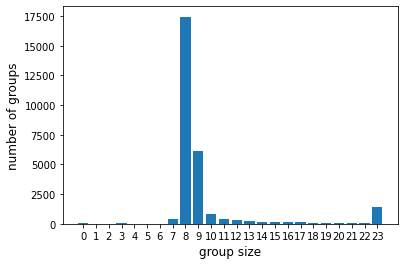

In [20]:
import matplotlib.pyplot as plt

x, y = zip(*list(partition_sizes.items()))
x_len=len(x)
plt.bar(x, y)
plt.xticks(x)
plt.xlabel("group size", fontsize="large")
plt.ylabel("number of groups", fontsize="large")

plt.rcParams["figure.figsize"] = (12,5)
plt.show()

Some post-processing:

In [21]:
print("We have", len(partitions), "partitions.")

We have 28500 partitions.


 Remove isolated words, and delete empty partitions:

In [24]:
cliques_members = load_obj("cliques_members_k_5", folder="/translation_graphs")
to_remove = maximal_members(cliques_members, 1)
print(len(to_remove), "singletons to remove.")

1228 singletons to remove.


In [25]:
# we remove empty partitions, included those which resulted empty after we removed a SINGLETONS (i.e. a token which we KNOW MUST BE ALONE)
corrected_partitions = []
for p in partitions:
  group = p
  # group = list(set(p) - set(to_remove))
  if len(group) > 0:
    corrected_partitions.append(group)

In [26]:
print("After removing empty partitions and isolated words we have", len(corrected_partitions), "partitions.")
singletons_list = [[s] for s in to_remove]
corrected_partitions.extend(singletons_list)
print("After adding the singletons, we have", len(corrected_partitions), "partitions.")

After removing empty partitions and isolated words we have 28450 partitions.
After adding the singletons, we have 29678 partitions.


We may still have some clusters containing words that are not connected in the graph, due to the nature of the used partition algorithm. We investigate this phenomenon analyzing the average intra-cluster path distance, looking at all combinations of tokens belonging to the same non-singleton cluster:

In [27]:
partition = corrected_partitions
sparse_graph = load_obj("k_5", folder="/translation_graphs/cliques")[2]

print("checking connections...")
path_lengths = defaultdict(lambda : 0)
no_path = 0

for pn, group in enumerate(partition):
  if len(group) > 1:
    import itertools
    pairs = list(itertools.combinations(group, r=2))
    for p in pairs:
      try:
        d = nx.shortest_path_length(sparse_graph, p[0], p[1])
        path_lengths[d] += 1
      except:
        no_path += 1

checking connections...


In [28]:
path_lengths = OrderedDict(sorted(path_lengths.items()))

In [29]:
x = [str(l) for l in list(path_lengths.keys())]
x.append("no_path")
y = list(path_lengths.values())
y.append(no_path)

print(x)
print(y)

['1', '2', '3', '4', '5', '6', '7', '8', 'no_path']
[454540, 497528, 228574, 99287, 39431, 8958, 642, 17, 7274]


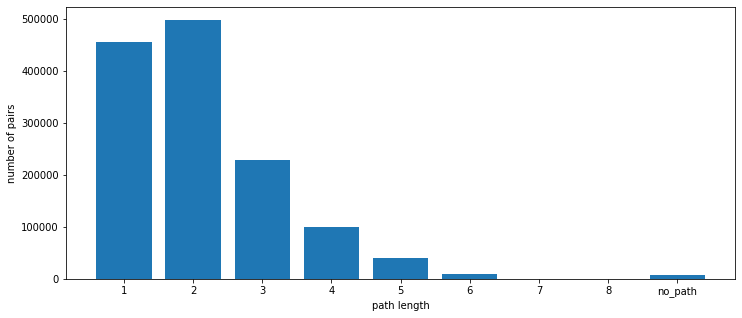

In [30]:
import matplotlib.pyplot as plt

plt.bar(x, y)
plt.xticks(x)
plt.xlabel("path length")
plt.ylabel("number of pairs")

plt.rcParams["figure.figsize"] = (10,8)

# plt.yscale('log')               # set scale

plt.show()

We now proceed by splitting the clusters made by non-connected tokens into multiple connected groups:

In [31]:
partition = corrected_partitions
print("checking connections...")

islands_to_add = []
partition_to_remove = []
for p_id, group in enumerate(partition):
  if len(group) > 1:
    for w in group:
      isolated = False
      island_members = [w]
      for mate in group:
        if w != mate:
          if not nx.has_path(sparse_graph, w, mate):
            isolated = True
            if not p_id in partition_to_remove:
              partition_to_remove.append(p_id)
          else:
            island_members.append(mate)
      if isolated:
        island = sorted(island_members)
        if not island in islands_to_add:
          islands_to_add.append(island)

checking connections...


In [32]:
print("to remove:", len(partition_to_remove))
print("to add:", len(islands_to_add))

to remove: 753
to add: 1931


In [33]:
partition = [partition[i] for i in range(len(partition)) if not i in partition_to_remove]
print("After removal of non-connected groups, we have", len(partition), "partitions.")
partition.extend(islands_to_add)
print("After adding the connected sub-groups, we have", len(partition), "partitions.")

After removal of non-connected groups, we have 28925 partitions.
After adding the connected sub-groups, we have 30856 partitions.


From a partition (list of lists of ids) create a tok_to_cID dictionary:

In [42]:
joint_voc_inv = load_obj("joint", folder = "/voc_dicts_inv")
special_tokens = load_obj("/special_tokens")

tok_to_cID = {}
for cID, p in enumerate(partition):
  for id in p:
    tok = joint_voc_inv[id]
    tok_to_cID[tok] = cID

count = len(partition)
for special in special_tokens:
  tok_to_cID[special] = count
  count += 1

Check that it works correctly:

In [43]:
cID_to_tok = inverse_dict(tok_to_cID)

print(len(tok_to_cID))
print(len(cID_to_tok))

270297
30293


Print some cluster examples:

In [44]:
for i in range(10):
  cID = np.random.randint(len(cID_to_tok))
  print(cID_to_tok[cID])

['নান_bn', '##udo_id', '타이_ko', '##타이_ko', '게이오_ko', '##aris_ru', 'anda_sw', 'sar_te', '##va_te']
['মিছিল_bn', 'rally_en', 'rallies_en', 'sanoitta_fi', 'sayembara_id', '공모_ko', '집회_ko', 'инициа_ru', '##ungana_sw']
['diac_en', 'wireless_id', '##cycl_ko', '##결에_ko', '내비_ko', '##oid_ru', '##tebbe_sw', '##pokeaji_sw']
['##zewa_sw', '##pr_sw', 'kusikiti_sw', '##lski_sw', 'ఊ_te', '##రుకు_te', '##రును_te', '##రులో_te', 'పనితీ_te']
['##جاعة_ar', 'قلادة_ar', 'فاير_ar', '##বডি_bn', 'কানুন_bn', '강력_ko', '##ంచర్_te', 'మొండి_te']
['توي_ar', 'سون_ar', '##জু_bn', '##াতু_bn', '##yo_en', 'yo_en', 'yo_fi', '##yo_fi']
['##فقات_ar', '##aine_fi', '##aineena_fi', '##aineita_fi', '##aineiden_fi', '##aineet_fi', 'поступления_ru', 'karanga_sw']
['##جاني_ar', '##nal_en', '##landers_en', 'hym_en', '##asta_en', 'haynes_en', 'шот_ru', '##శంకర_te']
['##ple_en', '##ples_en', '##rip_en', 'crip_en', '##мел_ru', '##плей_ru', '##స్లో_te', '##స్కు_te', '##స్ను_te']
['##ina_en', '##na_en', '##ena_en', '##na_fi', '##ta_id'

Finally, convert integers in strings and save the mapper:

In [45]:
tok_to_cID_string = {}
for k, v in tok_to_cID.items():
  tok_to_cID_string[k] = str(v)

In [46]:
for special_token in ["[PAD]", "[CLS]", "[SEP]", "[UNK]", "[MASK]"]:
  tok_to_cID_string[special_token] = special_token
save_obj(tok_to_cID_string, "/tok_to_cID_string")

# 5. Encoder Testing

Test that the encoder works. This is what is used to map text to cIDs:

In [53]:
from transformers import BertTokenizerFast

# from pytorch_transformers.tokenization_bert import BertTokenizer
ln = "en"
bt = BertTokenizerFast('/content/drive/MyDrive/notebooks/icebert_clustering/objects/for_tokenizer_vocabs/' + ln + '.txt', do_lower_case=False)

def fast_tokenize(text, ln, tokenizer):
  text = text.lower()
  text = ''.join("0" if c.isdigit() else c for c in text)
  tokens = bt.tokenize(text)
  for i, t in enumerate(tokens):
    tokens[i] = t + '_' + ln            
  return tokens

def encode_cID(sentence, ln, tok_to_cID, tokenizer, verbose=False):
  # tokens = tkn.tokenize(sentence, ln, tokenizer="BPEmb")
  tokens = fast_tokenize(sentence, ln, tokenizer)
  cIDs = []
  for t in tokens:
    try:
      id = tok_to_cID[t]
    except:
      try:
        id = tok_to_cID[t[:-3]]
      except:
        id = "UNK"
    cIDs.append(id)
  if verbose:
    print(tokens)
  return cIDs

In [54]:
tok_to_cID = load_obj("/tok_to_cID_string")
tokens = encode_cID("Goodmorning world!", ln, tok_to_cID, bt, verbose=True)
print(" ".join(tokens))

['good_en', '##morning_en', 'world_en', '!_en']
24289 20375 22825 31218
